In [123]:
import pandas as pd
import os
import glob
import re
import matplotlib.pyplot as plt
import numpy as np
import math
import torch
from pathlib import Path
import pickle
from matplotlib.ticker import MultipleLocator
from analysis import gaussian_parameter,bivariate_gaussian,gmm_overlap_score,load_pkl_by_timestep,replace_outliers_custom,compute_ttc_x,compute_ttc_y,adjust_ttc,add_tdtc
from matplotlib.patches import Ellipse
import matplotlib.colors as mcolors

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [124]:
plt.rcParams.update({
    'font.family': ['Cambria'],  
    'font.size': 13,
    'axes.titlesize': 13,
    'axes.labelsize': 13,
    'xtick.labelsize': 13,
    'ytick.labelsize': 13,
    'mathtext.fontset': 'cm',     
    'mathtext.rm': 'serif',       
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.spines.bottom': True,
    'axes.spines.left': True,
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.top': False,
    'xtick.bottom': True,
    'ytick.right': False,
    'ytick.left': True,
    'axes.grid': False,})

In [125]:
df=pd.read_csv('combined_data_car_ego_tianjing.csv')
df['Distance']=(df['near_x']**2+df['near_y']**2)**0.5
df=df[df['Distance']<10]

In [126]:
res_list=[{'a': 2.0192738887534705,
  'b': 2.3201198589419834,
  'mu': 0.9305650014060908,
  'sigma': 0.6109550640181163,
  'nll': 112782.31136811928},
 {'a': 2.121198859883311,
  'b': 2.5801449000125936,
  'mu': 1.0635442959911043,
  'sigma': 0.6224895259593011,
  'nll': 114787.6746358353},
 {'a': 2.132066120443428,
  'b': 3.3832000328804206,
  'mu': 1.0424222215052328,
  'sigma': 0.5913722493494209,
  'nll': 23348.55386926538}]

In [127]:
#csv_path = r"C:/Users/14487/python-book/safetyspace/absolute_ped/data.csv"  # 修改为你的路径
ub = 10.0           # 截断上界；需与拟合时一致
steps =2000        # 拟合步数
lr = 5e-3           # 学习率
MxNLL = MyNLL = 128 # 拟合时用的网格（越大越慢）
# 四个 v_ego 范围（开区间）；可按需改动
ranges = [(0,1),(1,3), (3, 15)]
# ========= 2) 读数据 & 分组 =========

def pick_xy(df, lo, hi):
    sub = df[(df["v"] > lo) & (df["v"] < hi) &
             (df["near_x"] > 0) & (df["near_y"] > 0)]
    XY = sub[["near_x", "near_y"]].to_numpy()
    return XY, len(sub)
xy_list, labels = [], []
for (lo, hi) in ranges:
    XY, n = pick_xy(df, lo, hi)
    print(n)
    xy_list.append(XY)
    labels.append(f"v∈({lo}, {hi})")

3881
10728
10577


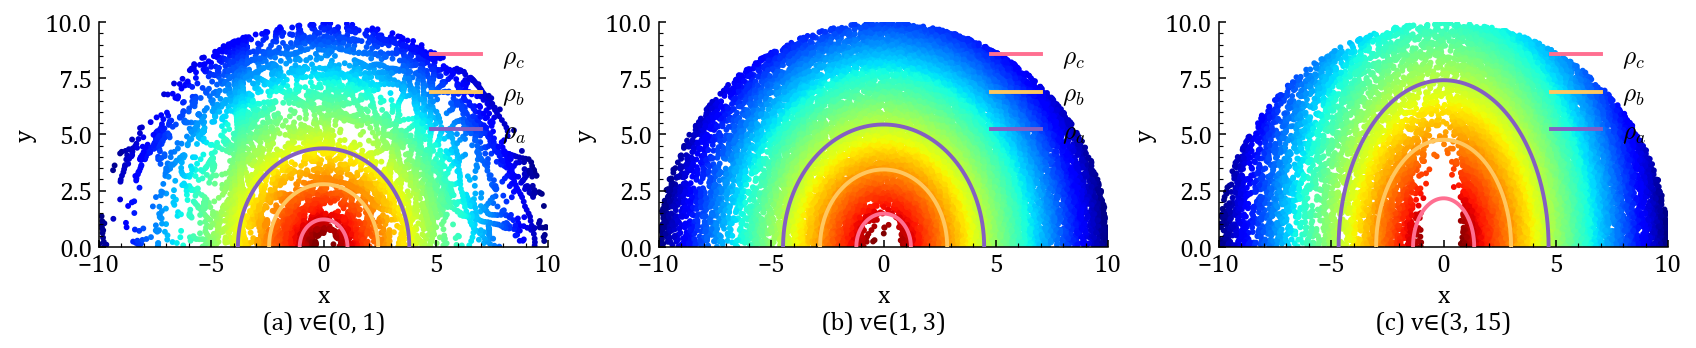

In [128]:
# --- 颜色（可改）---
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）
def rho_keypoints(mu, sigma):
    """返回 (rho_max', rho_0, rho_min')"""
    root = math.sqrt(1.0 + 4.0/(sigma**2))
    rho_max = math.exp(mu - 0.5*(sigma**2)*(5.0 + root))
    rho_0   = math.exp(mu - 2.0*(sigma**2))
    rho_min = math.exp(mu - 0.5*(sigma**2)*(5.0 - root))
    return rho_max, rho_0, rho_min
def ellipse_upper_half_points(a, b, rho, ub, n=720):
    """返回上半椭圆轨迹 (覆盖 x<0 与 x>0), 并裁剪到 [-ub, ub] × [0, ub]"""
    t = np.linspace(0.0, np.pi, n)
    x = a * rho * np.cos(t)
    y = b * rho * np.sin(t)
    m = (x >= -ub) & (x <= ub) & (y >= 0) & (y <= ub)
    return x[m], y[m]
# --- 速度分段（左闭右开，最后一段右闭）：[0,1), [1,3), [3,15] ---
speed_bins = [
    ("v ∈ [0, 1)",  lambda v: (v >= 0.0) & (v < 1.0)),
    ("v ∈ [1, 3)",  lambda v: (v >= 1.0) & (v < 3.0)),
    ("v ∈ [3, 15]", lambda v: (v >= 3.0) & (v <= 15.0)),
]
fig, axes = plt.subplots(1, 3, figsize=(12, 4.2), constrained_layout=True, dpi=140)
mappable = None
for ax, (res, lab), (range_lab, mask_fn), letter in zip(
    axes,
    zip(res_list[:3], labels[:3]),
    speed_bins[:3],
    "abc"):
    a = float(res["a"]); b = float(res["b"])
    mu = float(res["mu"]); sigma = float(res["sigma"])
    # 1) 底图：第一象限密度 + 沿 x 轴镜像补全到 [-ub, ub] × [0, ub]
    rho_max, rho_0, rho_min = rho_keypoints(mu, sigma)
    for rho, color, label in [
        (rho_max, COL_MAX,  r"$\rho_{c}$"),
        (rho_0,   COL_ZERO, r"$\rho_{b}$"),
        (rho_min, COL_MIN,  r"$\rho_{a}$"),
    ]:
        x_line, y_line = ellipse_upper_half_points(a, b, rho, ub)
        if len(x_line) > 1:
            ax.plot(x_line, y_line, color=color, lw=2.0, label=label, zorder=3)
    # 3) 落点：按速度分段筛 df，并按“半径越小越红”着色（用 jet_r）
    sub = df[mask_fn(df["v"])].copy()
    if len(sub) > 0:
        # 限制到当前绘图域
        dom = (sub["near_y"] >= 0) & (sub["near_y"] <= ub) & (np.abs(sub["near_x"]) <= ub)
        sub = sub[dom]
    if len(sub) > 0:
        rho_pts = np.sqrt( (sub["near_x"]/a)**2 + (sub["near_y"]/b)**2 )
        sc = ax.scatter(
            sub["near_x"], sub["near_y"],
            c=rho_pts, cmap="jet_r",  # 反转使半径越小越红
            s=4  )
        # 可选：也为点加专属 colorbar（注释掉即不显示）
        # plt.colorbar(sc, ax=ax, shrink=0.8, label="elliptical radius ρ")
    # ax.set_title(f"{lab}\n{range_lab}")
    ax.set_xlabel(f"x\n({letter}) {lab}"); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-ub, ub); ax.set_ylim(0, ub)
    ax.legend(loc="upper right", frameon=False)
# 共享色条（底图密度）
#fig.suptitle("Elliptical-Lognormal density + key ellipses + points by speed bins", y=0.995)
#plt.savefig('tianjin.png', dpi=220, bbox_inches='tight')
plt.show()

In [129]:
df[['Δx_car', 'Δy_car']] = df.groupby('track_id_car')[['x_car', 'y_car']].diff().fillna(0)
# df[['Δx_head', 'Δy_head']] = df.groupby('id')[['x', 'y']].diff(periods=2).fillna(0)

In [130]:
df[['Δx_ped', 'Δy_ped']] = df.groupby('track_id_ped')[['x_ped', 'y_ped']].diff().fillna(0)

In [131]:
def mark_regions_in_radians(angle_rad):
    if 0 <= angle_rad < math.pi / 8:  # 0 - 22.5度
        return 1
    elif math.pi / 8 <= angle_rad < 2 * math.pi / 8:  # 22.5 - 45度
        return 2
    elif 2 * math.pi / 8 <= angle_rad < 3 * math.pi / 8:  # 45 - 67.5度
        return 3
    elif 3 * math.pi / 8 <= angle_rad < 4 * math.pi / 8:  # 67.5 - 90度
        return 4
    elif 4 * math.pi / 8 <= angle_rad < 5 * math.pi / 8:  # 90 - 112.5度
        return 5
    elif 5 * math.pi / 8 <= angle_rad < 6 * math.pi / 8:  # 112.5 - 135度
        return 6
    elif 6 * math.pi / 8 <= angle_rad < 7 * math.pi / 8:  # 135 - 157.5度
        return 7
    elif 7 * math.pi / 8 <= angle_rad < math.pi:  # 157.5 - 180度
        return 8
    elif math.pi <= angle_rad < 9 * math.pi / 8:  # 180 - 202.5度
        return 9
    elif 9 * math.pi / 8 <= angle_rad < 10 * math.pi / 8:  # 202.5 - 225度
        return 10
    elif 10 * math.pi / 8 <= angle_rad < 11 * math.pi / 8:  # 225 - 247.5度
        return 11
    elif 11 * math.pi / 8 <= angle_rad < 12 * math.pi / 8:  # 247.5 - 270度
        return 12
    elif 12 * math.pi / 8 <= angle_rad < 13 * math.pi / 8:  # 270 - 292.5度
        return 13
    elif 13 * math.pi / 8 <= angle_rad < 14 * math.pi / 8:  # 292.5 - 315度
        return 14
    elif 14 * math.pi / 8 <= angle_rad < 15 * math.pi / 8:  # 315 - 337.5度
        return 15
    elif 15 * math.pi / 8 <= angle_rad < 2 * math.pi:  # 337.5 - 360度
        return 16
    else:
        return np.nan  # 如果不在 0 - 2π 范围内，标记为 NaN

In [132]:
def compute_angle(row):
    # 1️⃣ 取向量
    v1 = np.array([row['Δx_car'], row['Δy_car']])
    v2 = np.array([row['Δx_ped'], row['Δy_ped']])
    # 2️⃣ 零向量保护
    norm1, norm2 = np.linalg.norm(v1), np.linalg.norm(v2)
    if norm1 == 0 or norm2 == 0:
        return np.nan

    # 3️⃣ 各自的极角（逆时针为正）
    theta1 = math.atan2(v1[1], v1[0])   # v1 与 +x 轴的夹角
    theta2 = math.atan2(v2[1], v2[0])   # v2 与 +x 轴的夹角

    # 4️⃣ 顺时针角度：θ_cw = θ1 - θ2  (再转换到 0-360°)
    angle_cw = math.degrees(theta1 - theta2)
    angle_cw = (angle_cw + 360) % 360   # 保证落在 [0, 360)

    return angle_cw

In [133]:
combined_data_c= add_tdtc(df)

In [134]:
combined_data_c['TTC_x'] =combined_data_c.apply(compute_ttc_x, axis=1)
combined_data_c['TTC_y'] =combined_data_c.apply(compute_ttc_y, axis=1)
combined_data_c['TTC'] = combined_data_c.apply(adjust_ttc, axis=1)

In [135]:
x = combined_data_c['near_x'].values  # 提取 x 坐标
y = combined_data_c['near_y'].values  # 提取 y 坐标
angles_rad = (np.pi / 2 - np.arctan2(y, x)) % (2 * np.pi)  # 顺时针角度，弧度
angles_deg = np.degrees(angles_rad)  # 转换为角度
# 将结果添加到 DataFrame

In [136]:
combined_data_c['angle_radians'] = angles_rad
combined_data_c['angle_degrees'] = angles_deg
combined_data_c['region'] = combined_data_c['angle_radians'].apply(mark_regions_in_radians)
filtered_df = combined_data_c.loc[combined_data_c.groupby(['track_id_car','frame_id', 'region'])['Distance'].idxmin()]
# 重置索引以便更清晰
filtered_df = filtered_df.reset_index(drop=True)
filtered_df1=filtered_df[filtered_df['v_ego']>0]
# 应用到 DataFrame

In [137]:
filtered_df1['drive_angle_degrees'] =filtered_df1.apply(compute_angle, axis=1)
# 1. 先用 groupby 找到每个 (frame, id_car) 下 Distance 最小值所在的索引
# idx = filtered_df1.groupby(['frame', 'region'])['Distance'].idxmin()
# 2. 用 loc 按照这些索引筛选出对应行

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [138]:
#filtered_df1['TTC_risk']=1/filtered_df1['TTC']
filtered_df1['tdtc'] =filtered_df1['tdtc'].fillna(100000000)
filtered_df1['tdtc_risk']=1/abs(filtered_df1['tdtc'])

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
# 已知参数
params = {
    'a': 1.403769324457764,
    'b': 1.6893559639484577,
    'mu': 1.3998616562867765,
    'sigma': 0.6251638383865111}
a = params['a']
b = params['b']
mu = params['mu']
sigma = params['sigma']
# 常数项
C = 1.0 / (2 * np.pi * a * b * sigma * np.sqrt(2*np.pi))
def comfort_value(x, y):
    rho = np.sqrt((x/a)**2 + (y/b)**2)
    # 避免 rho=0 时除零
    if rho <= 1e-12:
        return 0.0
    return C * (rho**-2) * np.exp(-((np.log(rho) - mu)**2) / (2 * sigma**2))
# 假设 df 是你的 DataFrame，包含 near_x, near_y

In [140]:
filtered_df1['comfort'] =filtered_df1.apply(lambda row: comfort_value(row['near_x'], row['near_y']), axis=1)

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [141]:
# 先做一次全局上截断（<0.4）
#filtered_df1_tdtc_low = filtered_df1#[filtered_df1['tdtc_risk'] <400].copy()
def filter_percentile(group, risk):
    lower = group[risk].quantile(0.01)
    upper = group[risk].quantile(0.99)
    return group[(group[risk] >= lower) & (group[risk] <= upper)]

In [142]:
def data_pre(df, angle_ranges, risk):
    """
    Parameters
    ----------
    filtered_df1 : DataFrame
        必须包含列: 'drive_angle_degrees','near_x','near_y', risk
    angle_ranges : list[tuple]
        [(min_angle, max_angle), ...]，可含跨0度的区间（如 (350,360),(0,10) 分成两段传入即可）
    risk : str
        风险列名，如 'tdtc_risk'
    """

    # 1) 角度掩码（一次性向量化合并）
    ang = df['drive_angle_degrees'].to_numpy()
    mask = np.zeros(len(df), dtype=bool)
    for lo, hi in angle_ranges:
        mask |= (ang > lo) & (ang < hi)      # 若需包含端点改成 >= <=

    # 只筛一次，不 copy
    sub = df.loc[mask, ['near_x','near_y', risk]].copy()
    # 保留 near_x, near_y 用于后续角度计算
    # 若还需要其他列，可在上面的列列表里加上

    # 2) 分组内鲁棒截尾（更快：quantile + merge）
    #   2.1 计算每组的 1%/99% 分位
    q = sub.groupby(['near_x','near_y'])[risk].quantile([0.01, 0.99]).unstack(level=-1)
    q.columns = ['low', 'high']  # 对应 1%、99%
    q = q.reset_index()          # 变成普通列以便 merge

    #   2.2 回并到原数据（按 near_x, near_y 键）
    sub = sub.merge(q, on=['near_x','near_y'], how='left')

    #   2.3 一次性按每行所属组的低/高阈值过滤
    m_in = (sub[risk] >= sub['low']) & (sub[risk] <= sub['high'])
    sub = sub.loc[m_in, ['near_x','near_y', risk]].copy()

    # 3) 计算极角（向量化）
    x = sub['near_x'].to_numpy()
    y = sub['near_y'].to_numpy()
    angles_rad = (np.pi/2 - np.arctan2(y, x)) % (2*np.pi)
    sub['angle_radians'] = angles_rad
    sub['angle_degrees'] = np.degrees(angles_rad)

    # 4) 全局 1%/99% 再裁剪（可选；若不需要，直接 return sub）
    lo, hi = np.nanpercentile(sub[risk].to_numpy(), [1, 99])
    sub = sub.loc[(sub[risk] >= lo) & (sub[risk] <= hi)].reset_index(drop=True)

    return sub

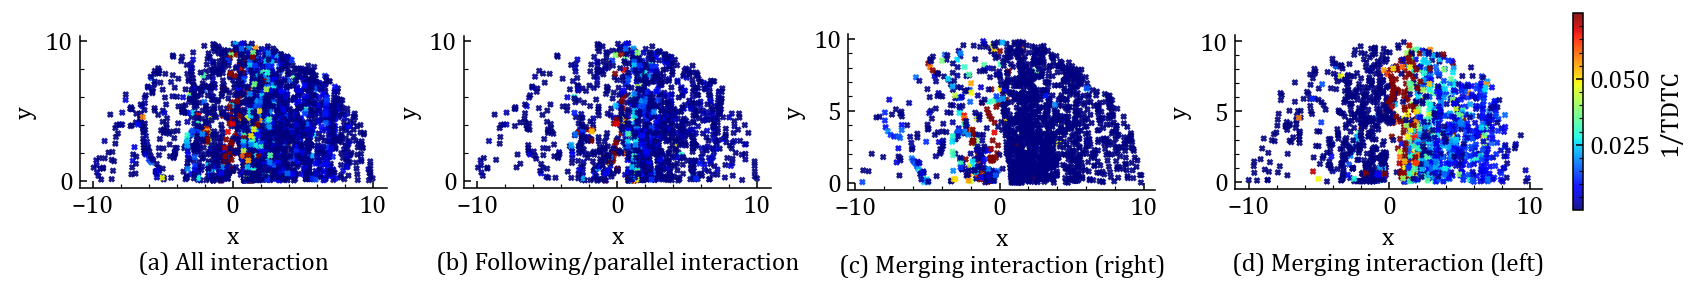

In [143]:
# 数据子集
all_ = data_pre(filtered_df1,[(0,10), (350,360)], 'tdtc_risk')
par  = data_pre(filtered_df1,[(0,5), (355,360)],  'tdtc_risk')
mer1 = data_pre(filtered_df1,[(5,20)],           'tdtc_risk')
mer2 = data_pre(filtered_df1,[(340,355)],        'tdtc_risk')

# 仅 y>0
all_1  = all_.loc[all_['near_y']  > 0]
par_1  = par.loc[par['near_y']    > 0]
mer1_1 = mer1.loc[mer1['near_y']  > 0]
mer2_1 = mer2.loc[mer2['near_y']  > 0]

datasets_labeled = [
    ("(a) All interaction",  all_1),
    ("(b) Following/parallel interaction",  par_1),
    ("(c) Merging interaction (right)", mer1_1),
    ("(d) Merging interaction (left)", mer2_1)]

# 统一色标范围
all_cr = np.concatenate([d["tdtc_risk"].to_numpy() for _, d in datasets_labeled])
vmin, vmax = np.nanpercentile(all_cr, [5, 95])
# 画图：1行4列 + 共享色条（与子图同高）
fig, axes = plt.subplots(1, 4, figsize=(12, 3.6), constrained_layout=True, dpi=140)
mappable = None
for ax, (title, df_plot) in zip(axes, datasets_labeled):
    sc = ax.scatter(df_plot["near_x"], df_plot["near_y"],
                    c=df_plot["tdtc_risk"], cmap="jet",
                    vmin=vmin, vmax=vmax, s=6, alpha=0.9,marker='x')
    ax.set_xlabel("x\n{}".format(title)); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    mappable = sc

cbar = fig.colorbar(mappable, ax=axes, location="right", pad=0.02, shrink=0.4)
cbar.set_label("1/TDTC")
#plt.savefig('TDTC.png', dpi=220, bbox_inches='tight')
plt.show()

In [144]:
filtered_df1['TTC_risk']=1/filtered_df1['TTC']

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


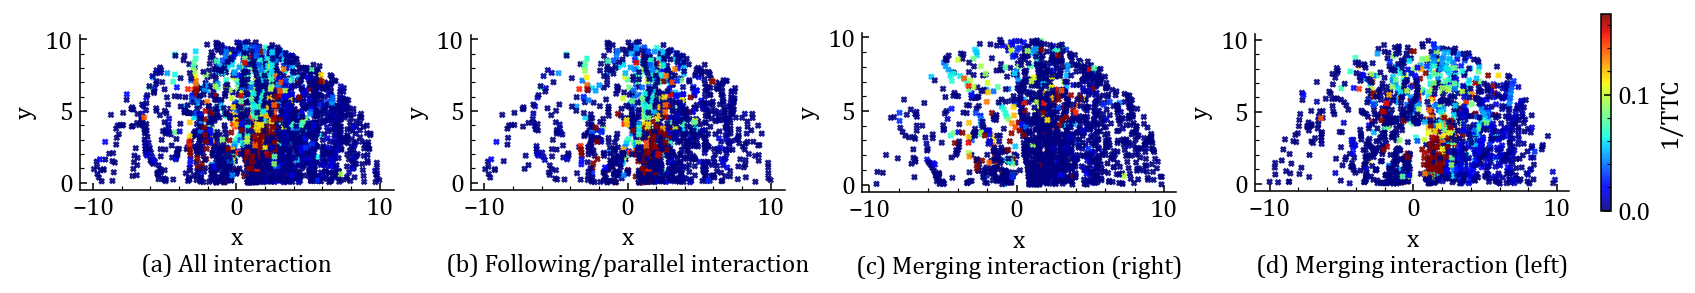

In [145]:
# 数据子集
all_ = data_pre(filtered_df1,[(0,10), (350,360)], 'TTC_risk')
par  = data_pre(filtered_df1,[(0,5), (355,360)],  'TTC_risk')
mer1 = data_pre(filtered_df1,[(5,20)],           'TTC_risk')
mer2 = data_pre(filtered_df1,[(340,355)],        'TTC_risk')

# 仅 y>0
all_1  = all_.loc[all_['near_y']  > 0]
par_1  = par.loc[par['near_y']    > 0]
mer1_1 = mer1.loc[mer1['near_y']  > 0]
mer2_1 = mer2.loc[mer2['near_y']  > 0]

datasets_labeled = [
    ("(a) All interaction",  all_1),
    ("(b) Following/parallel interaction",  par_1),
    ("(c) Merging interaction (right)", mer1_1),
    ("(d) Merging interaction (left)", mer2_1)]
# 统一色标范围
all_cr = np.concatenate([d["TTC_risk"].to_numpy() for _, d in datasets_labeled])
vmin, vmax = np.nanpercentile(all_cr, [5, 95])
# 画图：1行4列 + 共享色条（与子图同高）
fig, axes = plt.subplots(1, 4, figsize=(12, 3.6), constrained_layout=True, dpi=140)
mappable = None
for ax, (title, df_plot) in zip(axes, datasets_labeled):
    sc = ax.scatter(df_plot["near_x"], df_plot["near_y"],
                    c=df_plot["TTC_risk"], cmap="jet",
                    vmin=vmin, vmax=vmax, s=6, alpha=0.9,marker='x')
    ax.set_xlabel("x\n{}".format(title)); ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    mappable = sc
cbar = fig.colorbar(mappable, ax=axes, location="right", pad=0.02, shrink=0.4)
cbar.set_label("1/TTC")
#plt.savefig('TTC.png', dpi=220, bbox_inches='tight')
plt.show()

In [146]:
# 数据子集
all_ = data_pre(filtered_df1,[(0,10), (350,360)], 'comfort')
par  = data_pre(filtered_df1,[(0,5), (355,360)],  'comfort')
mer1 = data_pre(filtered_df1,[(5,20)],           'comfort')
mer2 = data_pre(filtered_df1,[(340,355)],        'comfort')
# 仅 y>0
all_1  = all_.loc[all_['near_y']  > 0]
par_1  = par.loc[par['near_y']    > 0]
mer1_1 = mer1.loc[mer1['near_y']  > 0]
mer2_1 = mer2.loc[mer2['near_y']  > 0]
datasets_labeled = [
    ("(a) All interaction",  all_1),
    ("(b) Following/parallel interaction",  par_1),
    ("(c) Merging interaction (right)", mer1_1),
    ("(d) Merging interaction (left)", mer2_1)]

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


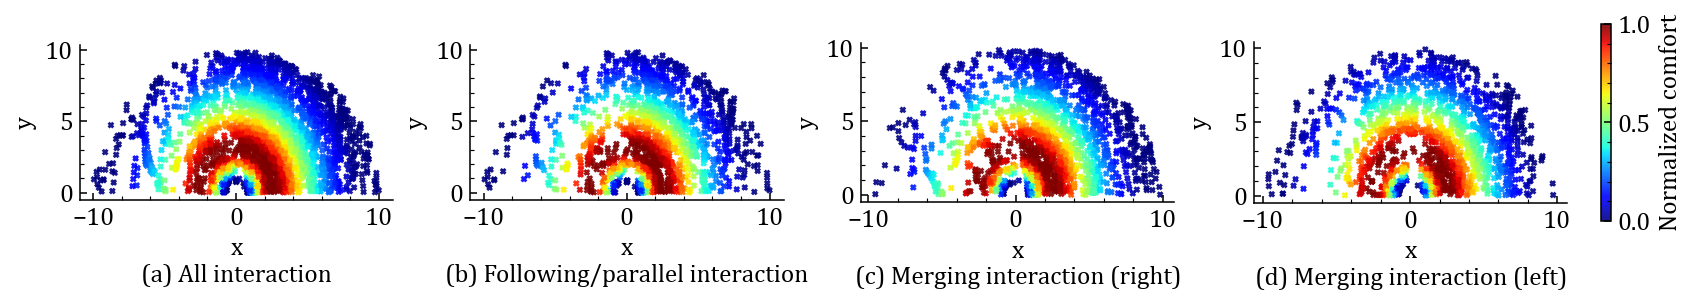

In [147]:
# 1) 计算全局色标范围（稳健：5–95 分位）
all_cr = np.concatenate([d["comfort"].to_numpy() for _, d in datasets_labeled])
vmin, vmax = np.nanpercentile(all_cr, [5, 95])
# 2) 为每个子集添加归一化列 comfort_norm ∈ [0,1]
def robust_minmax(x, lo, hi):
    return np.clip((x - lo) / (hi - lo + 1e-12), 0.0, 1.0)
for _, df_plot in datasets_labeled:
    df_plot["comfort_norm"] = robust_minmax(df_plot["comfort"].to_numpy(), vmin, vmax)
# 3) 画图（用归一化后的值做颜色；色条 0–1）
fig, axes = plt.subplots(1, 4, figsize=(12, 3.6), constrained_layout=True, dpi=140)
norm = mcolors.Normalize(vmin=0.0, vmax=1.0)
cmap = "jet"
mappable = None
for ax, (title, df_plot) in zip(axes, datasets_labeled):
    sc = ax.scatter(df_plot["near_x"], df_plot["near_y"],
                    c=df_plot["comfort_norm"], cmap=cmap, norm=norm,
                    s=6,marker='x', alpha=0.9)
    ax.set_xlabel(f"x\n{title}")
    ax.set_ylabel("y")
    ax.set_aspect("equal", adjustable="box")
    mappable = sc
# 与子图同高的颜色条（0–1）
cbar = fig.colorbar(mappable, ax=axes, location="right", pad=0.02, shrink=0.4)
cbar.set_label("Normalized comfort")
#plt.savefig('AR.png', dpi=220, bbox_inches='tight')
plt.show()

In [173]:
filtered_df1

,Unnamed: 0,track_id_car,frame_id,timestamp_ms_car,agent_type_car,x_car,y_car,vx_car,vy_car,yaw_rad,...,TTC_y,TTC,angle_radians,angle_degrees,region,drive_angle_degrees,tdtc_risk,comfort,TTC_risk,ci_label
0,367,7_28_1_108,7_28_1_2161,216316.316316,bicycle,20.901819,1.060398,-0.117003,3.731346,1.602229,...,1.000000e+07,inf,0.576571,33.035104,2,NaN,1.000000e-08,0.000963,0.0,other
1,369,7_28_1_108,7_28_1_2163,216516.516517,bicycle,20.877802,1.801946,-0.115650,3.684182,1.602208,...,1.511774e+01,inf,0.605941,34.717864,2,357.127696,3.011155e-03,0.001079,0.0,other
2,371,7_28_1_108,7_28_1_2165,216716.716717,bicycle,20.857533,2.532918,-0.114491,3.645150,1.602202,...,1.419735e+01,inf,0.639797,36.657665,2,3.119984,1.000000e-08,0.001199,0.0,other
3,373,7_28_1_108,7_28_1_2167,216916.916917,bicycle,20.838453,3.254409,-0.113854,3.623967,1.602201,...,1.333268e+01,inf,0.678303,38.863899,2,8.620444,1.000000e-08,0.001321,0.0,other
4,375,7_28_1_108,7_28_1_2169,217117.117117,bicycle,20.819843,3.972438,-0.113975,3.627488,1.602205,...,1.390838e+01,inf,0.716567,41.056256,2,8.134586,1.000000e-08,0.001432,0.0,other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127748,1001924,8_9_4_98,8_9_4_1972,197397.397397,bicycle,-9.110343,22.539852,-3.894061,-0.053597,-3.127762,...,8.870421e+01,inf,2.570503,147.278971,7,237.614137,1.000000e-08,0.002531,0.0,other
127749,1001925,8_9_4_98,8_9_4_1974,197597.597598,bicycle,-9.893450,22.571255,-3.890794,-0.053610,-3.127754,...,1.274533e+02,inf,2.632691,150.842055,7,46.105185,1.000000e-08,0.002291,0.0,other
127750,1001926,8_9_4_98,8_9_4_1976,197797.797798,bicycle,-10.677619,22.599141,-3.879025,-0.053533,-3.127736,...,1.232798e+02,inf,2.684975,153.837712,7,218.083540,1.000000e-08,0.002048,0.0,other
127751,1001927,8_9_4_98,8_9_4_1978,197997.997998,bicycle,-11.450024,22.620064,-3.863622,-0.053395,-3.127722,...,1.293484e+02,inf,2.728424,156.327193,7,232.216174,1.000000e-08,0.001813,0.0,other


In [149]:
# 小工具：给定一组参数，计算 comfort（向量化）
def comfort_ellip_logn(x, y, a, b, mu, sigma, eps=1e-12):
    rho = np.sqrt((x/a)**2 + (y/b)**2)
    rho_safe = np.maximum(rho, eps)  # 防止 rho=0
    C = 1.0 / (2*np.pi*a*b*sigma*np.sqrt(2*np.pi))
    return C * (rho_safe**-2) * np.exp(-((np.log(rho_safe)-mu)**2) / (2*sigma**2))

# 读取数据列
x = filtered_df1['near_x'].to_numpy()
y = filtered_df1['near_y'].to_numpy()
v = filtered_df1['v'].to_numpy()   # 速度（m/s），用于分段
m0 = (v >= 0.0) & (v < 1.0)
m1 = (v >= 1.0) & (v < 3.0)
m2 = (v >= 3.0) & (v <= 15.0)
comfort = np.full(len(filtered_df1), np.nan, dtype=float)
comfort[m0] = comfort_ellip_logn(x[m0], y[m0],res_list[0]['a'], res_list[0]['b'],res_list[0]['mu'], res_list[0]['sigma'])
comfort[m1] = comfort_ellip_logn(x[m1], y[m1],res_list[1]['a'], res_list[1]['b'],res_list[1]['mu'], res_list[1]['sigma'])
comfort[m2] = comfort_ellip_logn(x[m2], y[m2],res_list[2]['a'], res_list[2]['b'],res_list[2]['mu'], res_list[2]['sigma'])
filtered_df1['comfort'] = comfort

# --- 颜色（可改）---
COL_MAX  = '#FF6F91'  # 导数最大（上升最陡）
COL_ZERO = '#FFC75F'  # 导数=0（众值环）
COL_MIN  = '#845EC2'  # 导数最小（下降最陡）
def rho_keypoints(mu, sigma):
    """返回 (rho_max', rho_0, rho_min')"""
    root = math.sqrt(1.0 + 4.0/(sigma**2))
    rho_max = math.exp(mu - 0.5*(sigma**2)*(5.0 + root))
    rho_0   = math.exp(mu - 2.0*(sigma**2))
    rho_min = math.exp(mu - 0.5*(sigma**2)*(5.0 - root))
    return rho_max, rho_0, rho_min
def ellipse_upper_half_points(a, b, rho, ub, n=720):
    """返回上半椭圆轨迹 (覆盖 x<0 与 x>0), 并裁剪到 [-ub, ub] × [0, ub]"""
    t = np.linspace(0.0, np.pi, n)
    x = a * rho * np.cos(t)
    y = b * rho * np.sin(t)
    m = (x >= -ub) & (x <= ub) & (y >= 0) & (y <= ub)
    return x[m], y[m]
# --- 速度分段（左闭右开，最后一段右闭）：[0,1), [1,3), [3,15] ---
speed_bins = [
    ("v ∈ [0, 1)",  lambda v: (v >= 0.0) & (v < 1.0)),
    ("v ∈ [1, 3)",  lambda v: (v >= 1.0) & (v < 3.0)),
    ("v ∈ [3, 15]", lambda v: (v >= 3.0) & (v <= 15.0)),
]

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [150]:
assert len(res_list) >= 3, "res_list 至少需要包含 3 组参数（对应三段速度层）"
ci_label = np.full(len(filtered_df1), 'other', dtype=object)  # 默认 other，不参与作图
for idx, (_, mask_fn) in enumerate(speed_bins):
    m = mask_fn(v)               # 当前层样本掩码
    if not np.any(m):
        continue
    a = float(res_list[idx]['a']); b = float(res_list[idx]['b'])
    mu = float(res_list[idx]['mu']); sigma = float(res_list[idx]['sigma'])
    rho = np.sqrt((x[m]/a)**2 + (y[m]/b)**2)
    rho_c, rho_b, rho_a = rho_keypoints(mu, sigma)
    # 本层内局部掩码（相对 m 的索引）
    conflict_local    = (rho < rho_c)
    interaction_local = (rho >= rho_c) & (rho < rho_b)
    interaction_local_1 = (rho >= rho_b) & (rho < rho_a)
    # 映射回全局索引再赋值
    idx_m = np.flatnonzero(m)
    ci_label[idx_m[conflict_local]]    = 'conflict'
    ci_label[idx_m[interaction_local]] = 'interaction'
    ci_label[idx_m[interaction_local_1]] = 'interaction_1'
filtered_df1['ci_label'] = pd.Categorical(ci_label, categories=['conflict','interaction','interaction_1','other'])

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [151]:
pairs = filtered_df1[filtered_df1['ci_label']=='conflict'][['track_id_car','track_id_ped']].drop_duplicates()
pairs_set = set(map(tuple, pairs.values))

In [365]:
df.columns

Index(['Unnamed: 0', 'track_id_car', 'frame_id', 'timestamp_ms_car',
       'agent_type_car', 'x_car', 'y_car', 'vx_car', 'vy_car', 'yaw_rad',
       'heading_rad', 'length', 'width', 'ax_car', 'ay_car', 'v_lon', 'v_lat',
       'a_lon', 'a_lat', 'track_id_raw_car', 'frame_id_raw_car',
       'source_folder_car', 'agent_type_from_file_car', 'v_car', 'v_x_car',
       'v_y_car', 'track_id_ped', 'timestamp_ms_ped', 'agent_type_ped',
       'x_ped', 'y_ped', 'vx_ped', 'vy_ped', 'ax_ped', 'ay_ped',
       'track_id_raw_ped', 'frame_id_raw_ped', 'source_folder_ped',
       'agent_type_from_file_ped', 'v_x_ped', 'v_y_ped', 'v_ped', 'x_v', 'y_v',
       'v', 'v_ego', 'rel_x', 'rel_y', 'near_x', 'near_y', 'Distance',
       'Δx_car', 'Δy_car', 'Δx_ped', 'Δy_ped'],
      dtype='object')

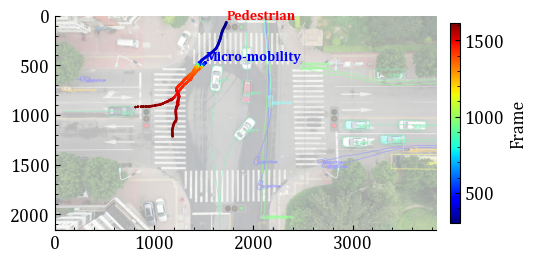

In [508]:
car3_ped7=filtered_df1[(filtered_df1['track_id_ped']=='7_28_1_P7')&(filtered_df1['track_id_car']=='7_28_1_3')][::1]
car3_ped7=car3_ped7.drop_duplicates(subset=['frame_id'])
frame_numbers=car3_ped7['frame_id'].apply(lambda x: int(x.split('_')[-1])).tolist()
car3_ped7['frame_numbers']=frame_numbers
car3_ped7 = car3_ped7.sort_values(by='frame_numbers').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))
# 背景图
ax.imshow(img, extent=[0, 3840, 0, 2160], origin='upper', zorder=0, alpha=0.4)
# 缩放因子
sx = 3840/(23.99+55.51)
sy = 2160/(7.643+38.69)
# 车辆轨迹
sc1 = ax.scatter(
    car3_ped7['x_car'] * sx + 23.99*sx,
    car3_ped7['y_car'] * sy + 7.64*sy,
    s=1, label='micro-mobility', c=car3_ped7['frame_numbers'],
    cmap='jet', marker='x'
)

# 行人轨迹
sc2 = ax.scatter(
    car3_ped7['x_ped'] * sx + 23.99*sx,
    car3_ped7['y_ped'] * sy + 7.64*sy,
    s=1, label='pedestrian', c=car3_ped7['frame_numbers'],
    cmap='jet'
)

# 起始点坐标（取第一个点）
x_car0 = car3_ped7['x_car'].iloc[0] * sx + 23.99*sx
y_car0 = car3_ped7['y_car'].iloc[0] * sy + 7.64*sy

x_ped0 = car3_ped7['x_ped'].iloc[0] * sx + 23.99*sx
y_ped0 = car3_ped7['y_ped'].iloc[0] * sy + 7.64*sy
# ax.scatter(car3_ped7[car3_ped7['frame_numbers']==378]['x_ped'] * sx + 23.99*sx,car3_ped7[car3_ped7['frame_numbers']==378]['y_ped']* sy + 7.64*sy,marker='x',s=100)
# ax.scatter(car3_ped7[car3_ped7['frame_numbers']==378]['x_car'] * sx + 23.99*sx,car3_ped7[car3_ped7['frame_numbers']==378]['y_car']* sy + 7.64*sy,marker='x',s=100)

# 标注起始位置
ax.text(x_car0, y_car0, "Micro-mobility", color='blue', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
ax.text(x_ped0, y_ped0,"Pedestrian", color='red', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
# 设置坐标轴
ax.set_xlim(0, 3840)
ax.set_ylim(2160, 0)  # 上方为0，向下增大
#ax.legend()
# 添加统一的颜色条
cbar = plt.colorbar(sc1, ax=ax, orientation='vertical', shrink=0.65,pad=0.03)
cbar.set_label('Frame')
# plt.tight_layout()
plt.savefig('tianjin_1.png', dpi=200, bbox_inches='tight')
plt.show()

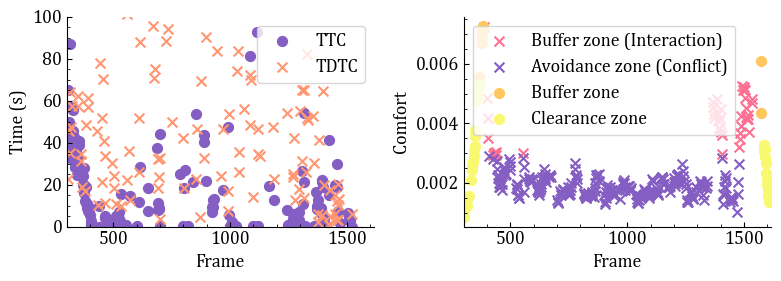

In [509]:
car3_ped7['TTC'] =car3_ped7['TTC'].replace([np.inf, -np.inf], np.nan)
car3_ped7['TDTC']=1/car3_ped7['tdtc_risk']
car3_ped7.loc[car3_ped7['TDTC'] > 1000, 'TDTC'] = np.nan
fig, axes = plt.subplots(1, 2, figsize=(8,3))  # 1行2列，整体宽10，高4
# -------- 子图1 --------
axes[0].scatter(car3_ped7['frame_numbers'], car3_ped7['TTC'], c='#845ec2',label='TTC',s=50)
axes[0].scatter(car3_ped7['frame_numbers'], car3_ped7['TDTC'], marker='x',c='#ff9671',label='TDTC',s=50)
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Time (s)")
axes[0].legend()
axes[0].set_ylim(0, 100)
#axes[0].grid(True)
axes[0].set_xlim([car3_ped7['frame_numbers'].min(),car3_ped7['frame_numbers'].max()])
# -------- 子图2 --------
car3_ped7_front = car3_ped7[car3_ped7['near_y'] > 0]

interaction = car3_ped7_front[car3_ped7_front['ci_label'] == 'interaction']
axes[1].scatter(interaction['frame_numbers'], interaction['comfort'], label='Buffer zone (Interaction)', c='#ff6f91',marker='x',s=50)

conflict = car3_ped7_front[car3_ped7_front['ci_label'] == 'conflict']
axes[1].scatter(conflict['frame_numbers'], conflict['comfort'], label='Avoidance zone (Conflict)', c='#845ec2',marker='x',s=50)

interaction_1 = car3_ped7_front[car3_ped7_front['ci_label'] == 'interaction_1']
axes[1].scatter(interaction_1['frame_numbers'], interaction_1['comfort'], label='Buffer zone', c='#ffc75f',s=50)

other = car3_ped7_front[car3_ped7_front['ci_label'] == 'other']
axes[1].scatter(other['frame_numbers'], other['comfort'], label='Clearance zone', c='#f9f871',s=50)


axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Comfort")
axes[1].legend()
#axes[1].grid(True)
axes[1].set_xlim([car3_ped7['frame_numbers'].min(),car3_ped7['frame_numbers'].max()])
# -------- 布局调整 --------
plt.tight_layout()
plt.savefig('tianjin_comfort_1.png', dpi=200, bbox_inches='tight')
plt.show()

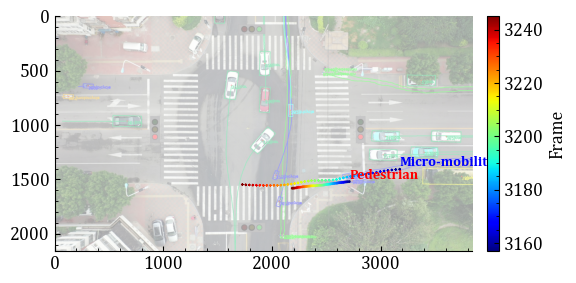

In [551]:
car176_ped9=filtered_df1[(filtered_df1['track_id_ped']==list(pairs_set)[55][1])&(filtered_df1['track_id_car']==list(pairs_set)[55][0])][::1]
ca176_ped9=car176_ped9.drop_duplicates(subset=['frame_id'])
frame_numbers=car176_ped9['frame_id'].apply(lambda x: int(x.split('_')[-1])).tolist()
car176_ped9['frame_numbers']=frame_numbers
car176_ped9 = car176_ped9.sort_values(by='frame_numbers').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))
# 背景图
ax.imshow(img, extent=[0, 3840, 0, 2160], origin='upper', zorder=0, alpha=0.4)
# 缩放因子
sx = 3840/(23.99+55.51)
sy = 2160/(7.643+38.69)
# 车辆轨迹
sc1 = ax.scatter(
    car176_ped9['x_car'] * sx + 23.99*sx,
    car176_ped9['y_car'] * sy + 7.64*sy,
    s=1, label='micro-mobility', c=car176_ped9['frame_numbers'],
    cmap='jet', marker='x'
)

# 行人轨迹
sc2 = ax.scatter(
    car176_ped9['x_ped'] * sx + 23.99*sx,
    car176_ped9['y_ped'] * sy + 7.64*sy,
    s=1, label='pedestrian', c=car176_ped9['frame_numbers'],
    cmap='jet'
)

# 起始点坐标（取第一个点）
x_car0 = car176_ped9['x_car'].iloc[0] * sx + 23.99*sx
y_car0 = car176_ped9['y_car'].iloc[0] * sy + 7.64*sy

x_ped0 = car176_ped9['x_ped'].iloc[0] * sx + 23.99*sx
y_ped0 = car176_ped9['y_ped'].iloc[0] * sy + 7.64*sy


ax.scatter(car176_ped9[car176_ped9['frame_numbers']==5567]['x_ped'] * sx + 23.99*sx,car176_ped9[car176_ped9['frame_numbers']==5567]['y_ped']* sy + 7.64*sy,marker='x',s=50)
ax.scatter(car176_ped9[car176_ped9['frame_numbers']==5567]['x_car'] * sx + 23.99*sx,car176_ped9[car176_ped9['frame_numbers']==5567]['y_car']* sy + 7.64*sy,marker='x',s=50)

# 标注起始位置
ax.text(x_car0, y_car0, "Micro-mobility", color='blue', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
ax.text(x_ped0, y_ped0,"Pedestrian", color='red', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
# 设置坐标轴
ax.set_xlim(0, 3840)
ax.set_ylim(2160, 0)  # 上方为0，向下增大
#ax.legend()
# 添加统一的颜色条
cbar = plt.colorbar(sc1, ax=ax, orientation='vertical', shrink=0.65,pad=0.03)
cbar.set_label('Frame')
plt.tight_layout()
plt.savefig('tianjin_2.png', dpi=200, bbox_inches='tight')
plt.show()

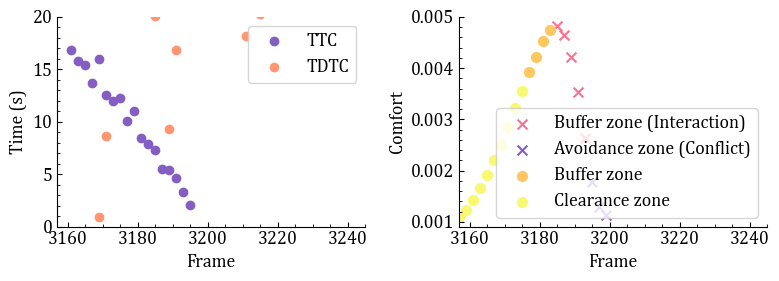

In [552]:
car176_ped9['TTC'] =car176_ped9['TTC'].replace([np.inf, -np.inf], np.nan)
car176_ped9['TDTC']=1/car176_ped9['tdtc_risk']
car176_ped9.loc[car176_ped9['TDTC'] > 1000, 'TDTC'] = np.nan
fig, axes = plt.subplots(1, 2, figsize=(8,3))  # 1行2列，整体宽10，高4

# -------- 子图1 --------
axes[0].scatter(car176_ped9['frame_numbers'], car176_ped9['TTC'],  c='#845ec2',label='TTC')
axes[0].scatter(car176_ped9['frame_numbers'], car176_ped9['TDTC'], c='#ff9671',label='TDTC')
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Time (s)")
axes[0].legend()
axes[0].set_ylim(0,20)
axes[0].set_xlim([car176_ped9['frame_numbers'].min(),car176_ped9['frame_numbers'].max()])
# -------- 子图2 --------
car176_ped9_front = car176_ped9[car176_ped9['near_y'] > 0]
interaction = car176_ped9_front[car176_ped9_front['ci_label'] == 'interaction']
axes[1].scatter(interaction['frame_numbers'], interaction['comfort'], label='Buffer zone (Interaction)', c='#ff6f91',marker='x',s=50)
conflict = car176_ped9_front[car176_ped9_front['ci_label'] == 'conflict']
axes[1].scatter(conflict['frame_numbers'], conflict['comfort'], label='Avoidance zone (Conflict)', c='#845ec2',marker='x',s=50)
interaction_1 = car176_ped9_front[car176_ped9_front['ci_label'] == 'interaction_1']
axes[1].scatter(interaction_1['frame_numbers'], interaction_1['comfort'], label='Buffer zone', c='#ffc75f',s=50)
other = car176_ped9_front[car176_ped9_front['ci_label'] == 'other']
axes[1].scatter(other['frame_numbers'], other['comfort'], label='Clearance zone', c='#f9f871',s=50)

axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Comfort")
axes[1].legend()
axes[1].set_xlim([car176_ped9['frame_numbers'].min(),car176_ped9['frame_numbers'].max()])
# -------- 布局调整 --------
plt.tight_layout()
plt.savefig('tianjin_comfort_2.png', dpi=200, bbox_inches='tight')
plt.show()

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


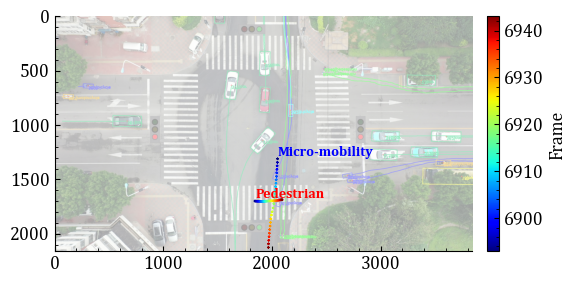

In [553]:
car176_ped9=filtered_df1[(filtered_df1['track_id_ped']==list(pairs_set)[27][1])&(filtered_df1['track_id_car']==list(pairs_set)[27][0])]
ca176_ped9=car176_ped9.drop_duplicates(subset=['frame_id'])
frame_numbers=car176_ped9['frame_id'].apply(lambda x: int(x.split('_')[-1])).tolist()
car176_ped9['frame_numbers']=frame_numbers
car176_ped9 = car176_ped9.sort_values(by='frame_numbers').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))
# 背景图
ax.imshow(img, extent=[0, 3840, 0, 2160], origin='upper', zorder=0, alpha=0.4)
# 缩放因子
sx = 3840/(23.99+55.51)
sy = 2160/(7.643+38.69)
# 车辆轨迹
sc1 = ax.scatter(
    car176_ped9['x_car'] * sx + 23.99*sx,
    car176_ped9['y_car'] * sy + 7.64*sy,
    s=1, label='micro-mobility', c=car176_ped9['frame_numbers'],
    cmap='jet', marker='x'
)

# 行人轨迹
sc2 = ax.scatter(
    car176_ped9['x_ped'] * sx + 23.99*sx,
    car176_ped9['y_ped'] * sy + 7.64*sy,
    s=1, label='pedestrian', c=car176_ped9['frame_numbers'],
    cmap='jet'
)

# 起始点坐标（取第一个点）
x_car0 = car176_ped9['x_car'].iloc[0] * sx + 23.99*sx
y_car0 = car176_ped9['y_car'].iloc[0] * sy + 7.64*sy

x_ped0 = car176_ped9['x_ped'].iloc[0] * sx + 23.99*sx
y_ped0 = car176_ped9['y_ped'].iloc[0] * sy + 7.64*sy


ax.scatter(car176_ped9[car176_ped9['frame_numbers']==5567]['x_ped'] * sx + 23.99*sx,car176_ped9[car176_ped9['frame_numbers']==5567]['y_ped']* sy + 7.64*sy,marker='x',s=50)
ax.scatter(car176_ped9[car176_ped9['frame_numbers']==5567]['x_car'] * sx + 23.99*sx,car176_ped9[car176_ped9['frame_numbers']==5567]['y_car']* sy + 7.64*sy,marker='x',s=50)

# 标注起始位置
ax.text(x_car0, y_car0, "Micro-mobility", color='blue', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
ax.text(x_ped0, y_ped0,"Pedestrian", color='red', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
# 设置坐标轴
ax.set_xlim(0, 3840)
ax.set_ylim(2160, 0)  # 上方为0，向下增大
#ax.legend()
# 添加统一的颜色条
cbar = plt.colorbar(sc1, ax=ax, orientation='vertical', shrink=0.65,pad=0.03)
cbar.set_label('Frame')
plt.tight_layout()
plt.show()

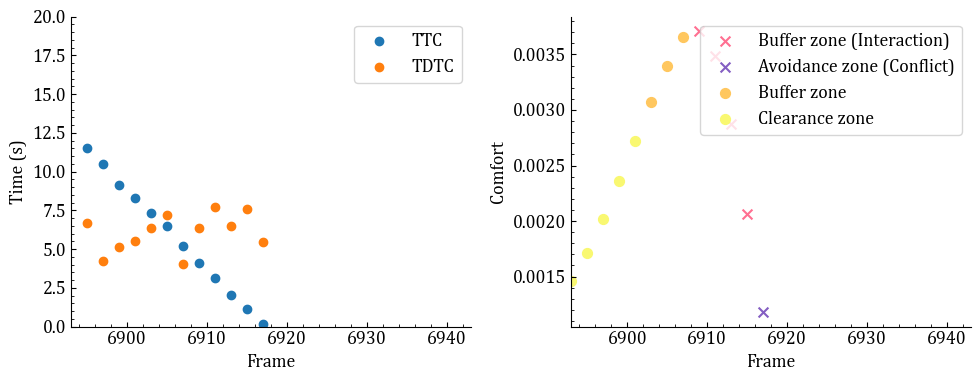

In [556]:
car176_ped9['TTC'] =car176_ped9['TTC'].replace([np.inf, -np.inf], np.nan)
car176_ped9['TDTC']=1/car176_ped9['tdtc_risk']
car176_ped9.loc[car176_ped9['TDTC'] > 1000, 'TDTC'] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1行2列，整体宽10，高4

# -------- 子图1 --------
axes[0].scatter(car176_ped9['frame_numbers'], car176_ped9['TTC'],  c='#845ec2',label='TTC')
axes[0].scatter(car176_ped9['frame_numbers'], car176_ped9['TDTC'], c='#ff9671',label='TDTC')
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Time (s)")
axes[0].legend()
axes[0].set_ylim(0,20)
axes[0].set_xlim([car176_ped9['frame_numbers'].min(),car176_ped9['frame_numbers'].max()])

# -------- 子图2 --------
car176_ped9_front = car176_ped9[car176_ped9['near_y'] > 0]

interaction = car176_ped9_front[car176_ped9_front['ci_label'] == 'interaction']
axes[1].scatter(interaction['frame_numbers'], interaction['comfort'], label='Buffer zone (Interaction)', c='#ff6f91',marker='x',s=50)
conflict = car176_ped9_front[car176_ped9_front['ci_label'] == 'conflict']
axes[1].scatter(conflict['frame_numbers'], conflict['comfort'], label='Avoidance zone (Conflict)', c='#845ec2',marker='x',s=50)
interaction_1 = car176_ped9_front[car176_ped9_front['ci_label'] == 'interaction_1']
axes[1].scatter(interaction_1['frame_numbers'], interaction_1['comfort'], label='Buffer zone', c='#ffc75f',s=50)
other = car176_ped9_front[car176_ped9_front['ci_label'] == 'other']
axes[1].scatter(other['frame_numbers'], other['comfort'], label='Clearance zone', c='#f9f871',s=50)

axes[1].set_xlim([car176_ped9['frame_numbers'].min(),car176_ped9['frame_numbers'].max()])
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Comfort")
axes[1].legend()

# -------- 布局调整 --------
plt.tight_layout()
plt.show()

C:\Users\14487\anaconda3\envs\MARL\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


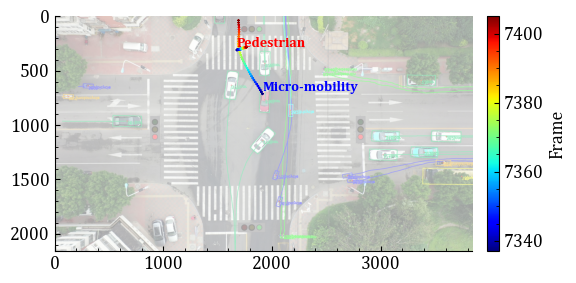

In [589]:
car176_ped9=filtered_df1[(filtered_df1['track_id_ped']==list(pairs_set)[28][1])&(filtered_df1['track_id_car']==list(pairs_set)[28][0])]
ca176_ped9=car176_ped9.drop_duplicates(subset=['frame_id'])
frame_numbers=car176_ped9['frame_id'].apply(lambda x: int(x.split('_')[-1])).tolist()
car176_ped9['frame_numbers']=frame_numbers
car176_ped9 = car176_ped9.sort_values(by='frame_numbers').reset_index(drop=True)

fig, ax = plt.subplots(figsize=(6,4))
# 背景图
ax.imshow(img, extent=[0, 3840, 0, 2160], origin='upper', zorder=0, alpha=0.4)
# 缩放因子
sx = 3840/(23.99+55.51)
sy = 2160/(7.643+38.69)
# 车辆轨迹
sc1 = ax.scatter(
    car176_ped9['x_car'] * sx + 23.99*sx,
    car176_ped9['y_car'] * sy + 7.64*sy,
    s=1, label='micro-mobility', c=car176_ped9['frame_numbers'],
    cmap='jet', marker='x'
)

# 行人轨迹
sc2 = ax.scatter(
    car176_ped9['x_ped'] * sx + 23.99*sx,
    car176_ped9['y_ped'] * sy + 7.64*sy,
    s=1, label='pedestrian', c=car176_ped9['frame_numbers'],
    cmap='jet'
)

# 起始点坐标（取第一个点）
x_car0 = car176_ped9['x_car'].iloc[0] * sx + 23.99*sx
y_car0 = car176_ped9['y_car'].iloc[0] * sy + 7.64*sy

x_ped0 = car176_ped9['x_ped'].iloc[0] * sx + 23.99*sx
y_ped0 = car176_ped9['y_ped'].iloc[0] * sy + 7.64*sy


# ax.scatter(car176_ped9[car176_ped9['frame_numbers']==5567]['x_ped'] * sx + 23.99*sx,car176_ped9[car176_ped9['frame_numbers']==5567]['y_ped']* sy + 7.64*sy,marker='x',s=50)
# ax.scatter(car176_ped9[car176_ped9['frame_numbers']==5567]['x_car'] * sx + 23.99*sx,car176_ped9[car176_ped9['frame_numbers']==5567]['y_car']* sy + 7.64*sy,marker='x',s=50)

# 标注起始位置
ax.text(x_car0, y_car0, "Micro-mobility", color='blue', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
ax.text(x_ped0, y_ped0,"Pedestrian", color='red', fontsize=10,
        ha='left', va='bottom', fontweight='bold')
# 设置坐标轴
ax.set_xlim(0, 3840)
ax.set_ylim(2160, 0)  # 上方为0，向下增大
#ax.legend()
# 添加统一的颜色条
cbar = plt.colorbar(sc1, ax=ax, orientation='vertical', shrink=0.65,pad=0.03)
cbar.set_label('Frame')
plt.tight_layout()
plt.savefig('tianjin_3.png', dpi=200, bbox_inches='tight')
plt.show()

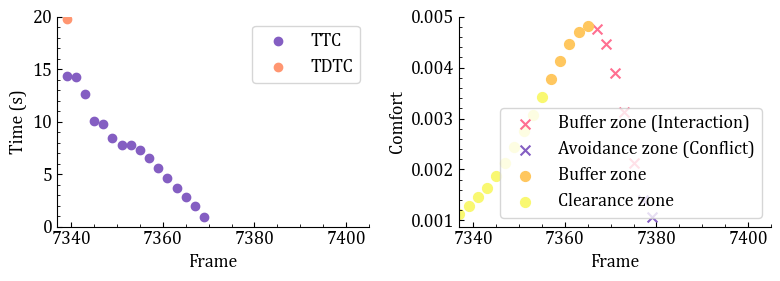

In [591]:
car176_ped9['TTC'] =car176_ped9['TTC'].replace([np.inf, -np.inf], np.nan)
car176_ped9['TDTC']=1/car176_ped9['tdtc_risk']
car176_ped9.loc[car176_ped9['TDTC'] > 1000, 'TDTC'] = np.nan

fig, axes = plt.subplots(1, 2, figsize=(8,3))  # 1行2列，整体宽10，高4

# -------- 子图1 --------
axes[0].scatter(car176_ped9['frame_numbers'], car176_ped9['TTC'],  c='#845ec2',label='TTC')
axes[0].scatter(car176_ped9['frame_numbers'], car176_ped9['TDTC'], c='#ff9671',label='TDTC')
axes[0].set_xlabel("Frame")
axes[0].set_ylabel("Time (s)")
axes[0].legend()
axes[0].set_ylim(0,20)
axes[0].set_xlim([car176_ped9['frame_numbers'].min(),car176_ped9['frame_numbers'].max()])

# -------- 子图2 --------
car176_ped9_front = car176_ped9[car176_ped9['near_y'] > 0]
interaction = car176_ped9_front[car176_ped9_front['ci_label'] == 'interaction']
axes[1].scatter(interaction['frame_numbers'], interaction['comfort'], label='Buffer zone (Interaction)', c='#ff6f91',marker='x',s=50)
conflict = car176_ped9_front[car176_ped9_front['ci_label'] == 'conflict']
axes[1].scatter(conflict['frame_numbers'], conflict['comfort'], label='Avoidance zone (Conflict)', c='#845ec2',marker='x',s=50)
interaction_1 = car176_ped9_front[car176_ped9_front['ci_label'] == 'interaction_1']
axes[1].scatter(interaction_1['frame_numbers'], interaction_1['comfort'], label='Buffer zone', c='#ffc75f',s=50)
other = car176_ped9_front[car176_ped9_front['ci_label'] == 'other']
axes[1].scatter(other['frame_numbers'], other['comfort'], label='Clearance zone', c='#f9f871',s=50)
axes[1].set_xlabel("Frame")
axes[1].set_ylabel("Comfort")
axes[1].legend()
axes[1].set_xlim([car176_ped9['frame_numbers'].min(),car176_ped9['frame_numbers'].max()])
# -------- 布局调整 --------
plt.tight_layout()
plt.savefig('tianjin_comfort_3.png', dpi=200, bbox_inches='tight')
plt.show()

In [566]:
len(pairs_set)

147

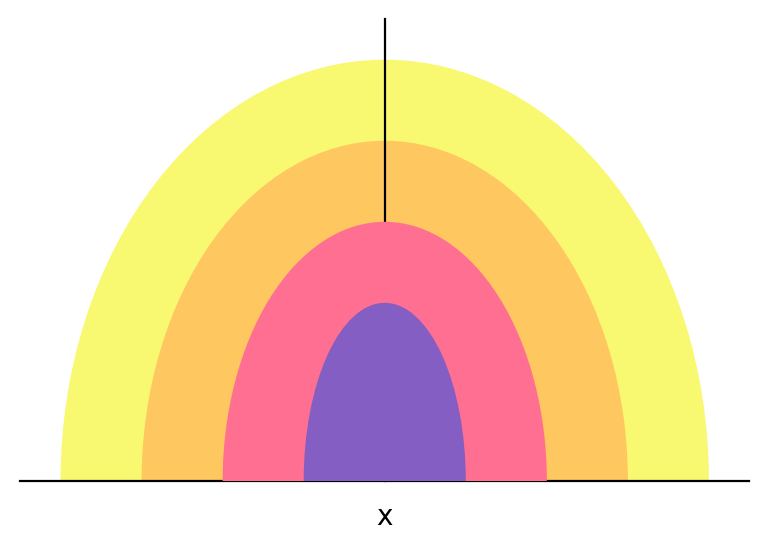

In [17]:
a1, b1 = 1, 2.2
a2, b2 = 2, 3.2
a3, b3 = 3, 4.2
a4, b4 = 4, 5.2

COL1 = "#845ec2"
COL2 = "#ff6f91"
COL3 = "#ffc75f"
COL4 = "#f9f871"

fig, ax = plt.subplots(figsize=(8,3), dpi=200)
for (a,b,c,z) in [
    (a4,b4,COL4,1),
    (a3,b3,COL3,2),
    (a2,b2,COL2,3),
    (a1,b1,COL1,4),
]:
    ax.add_patch(Ellipse((0,0), 2*a, 2*b, facecolor=c, edgecolor='none', zorder=z))

ax.set_xlim(-a4-0.5, a4+0.5)
ax.set_ylim(0, b4+0.5)
ax.set_aspect('equal', adjustable='box')

ax.spines['left'].set_position('zero')
ax.spines['bottom'].set_position('zero')
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.grid(False)
ax.set_xticks([])  # 清空 x 轴刻度
ax.set_yticks([])  # 清空 x 轴刻度

#out_path = "/mnt/data/elliptical_zones_halfplane_4.png"
plt.savefig('buffer.png', bbox_inches='tight', dpi=200)
plt.show()